# Proyecto 04 - Informe Final Carrera

**Problema:** Recientemente te has incorporado al equipo de Datos de una gran inmobiliaria. La primera tarea que se te asigna es ayudar a los tasadores/as a valuar las propiedades, ya que es un proceso difícil y, a veces, subjetivo. Para ello, propones crear un modelo de Machine Learning que, dadas ciertas características de la propiedad, prediga su precio de venta.

**Dataset:** Propiedades en venta publicado en el portal [Properati](https://drive.google.com/file/d/1-QxCApNKvzaCEOcnAiKnqiAqnd1NtSow/view?usp=sharing)

**Objetivo:** En base a los resultados obtenidos durante el Proyecto 2, se implementarán otros análisis con el fin de mejorar o expandir el modelo obtenido.
* Agregar las propiedades de Gran Buenos Aires
* Dividir el mejor modelo obtenido anteriormente en varios según el tipo de propiedad o según la ubicación.
* Mejorar la eliminación de outliers

*Link a GitHub: https://github.com/MarielMaugeri/Proyecto_4-Acamica

## Librerías utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
import matplotlib.patches as mpatches

## Análisis Exploratorio de Datos

En cuanto al análisis de los datos se aplicaron los mismos filtrados que en el proyecto anterior como punto de partida y se procedió a realizar los nuevos análisis

In [2]:
#Importamos el Dataset
propiedades = pd.read_csv("DS_Proyecto_01_Datos_Properati.csv")

In [3]:
print("Tamaño del dataset:", propiedades.shape)

Tamaño del dataset: (146660, 19)


**Eliminación de columnas**

Se eliminaron las columnas que no se van a utilizar ("start_date", "end_date", "created_on", "title", "description") o que contiene el mismo dato en todas sus filas ("l1", "currency", "operation_type").

In [4]:
propiedades = propiedades.drop(columns = ["start_date", "end_date", "created_on", "title", "description", "l1", "currency", "operation_type"])

**Tipo de propiedades y ubicación**

Al igual que como se vino trabajando para los proyectos anteriores se seleccionaron solo los "Departamentos", "Casas" y "PH", pero en este caso se trabajó tanto con Capital como Gran Buenos Aires, unificando las tres zonas en las que está dividido este último

In [5]:
propiedades["l2"].unique()

array(['Capital Federal', 'Bs.As. G.B.A. Zona Sur',
       'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste'],
      dtype=object)

In [6]:
propiedades["l2"].replace(to_replace = ["Bs.As. G.B.A. Zona Sur", "Bs.As. G.B.A. Zona Norte", "Bs.As. G.B.A. Zona Oeste"], value = "Bs.As. G.B.A.", inplace = True)

In [7]:
mask_type = propiedades.property_type.isin(["Departamento", "Casa", "PH"])
propiedades = propiedades[mask_type]

Text(0.5, 1.0, 'Cantidad de propiedades por cada zona')

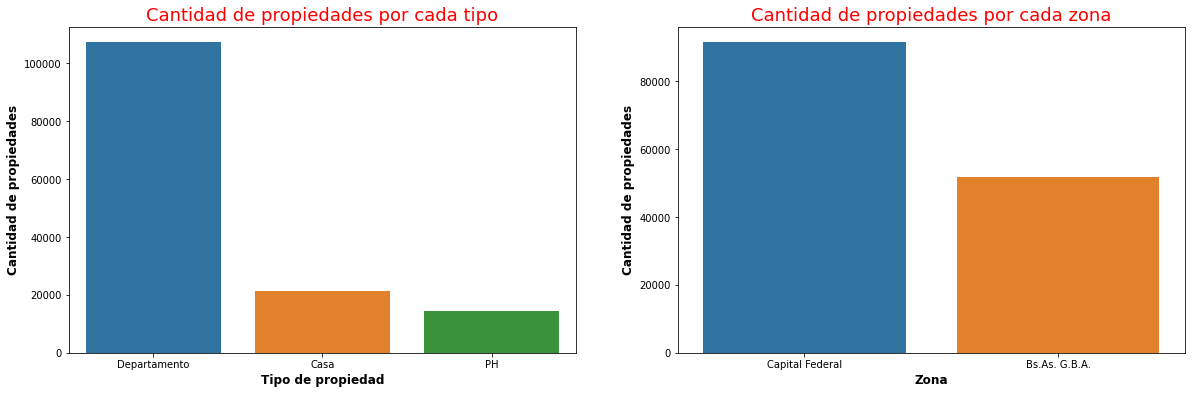

In [8]:
plt.figure(figsize = (20,6))

plt.subplot(1,2,1)
sns.countplot(x = "property_type", data = propiedades, order = propiedades['property_type'].value_counts().index)
plt.xlabel("Tipo de propiedad", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad de propiedades", fontweight = "black", fontsize = 12)
plt.title("Cantidad de propiedades por cada tipo", fontsize=18, color="red")

plt.subplot(1,2,2)
sns.countplot(x = "l2", data = propiedades, order = propiedades['l2'].value_counts().index)
plt.xlabel("Zona", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad de propiedades", fontweight = "black", fontsize = 12)
plt.title("Cantidad de propiedades por cada zona", fontsize=18, color="red")

In [9]:
print("Tamaño del Data Frame filtrado:", propiedades.shape)

Tamaño del Data Frame filtrado: (143145, 11)


Se le cambió el nombre a las columnas para poder uitilizar sus nombre en los gráficos

In [10]:
propiedades.columns

Index(['lat', 'lon', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'property_type'],
      dtype='object')

In [11]:
propiedades.columns = ["Latitud", "Longitud", "Ubicacion", "Barrios", "Ambientes", "Habitaciones", "Baños", "Superficie_total(m2)", "Superficie_cubierta(m2)", "Precio(USD)", "Tipo_propiedad"]

### Eliminación de outliers

En primer lugar se realizó una eliminación según reglas de lógica como ser que la superficie cubierta no puede ser mayor a la total, y que el nro de habitaciones es menor al nro de ambientes.

In [12]:
propiedades = propiedades[(propiedades["Superficie_total(m2)"] >= propiedades["Superficie_cubierta(m2)"]) & (propiedades["Ambientes"] > propiedades["Habitaciones"])]

In [13]:
print("Tamaño del Data Frame filtrado:", propiedades.shape)

Tamaño del Data Frame filtrado: (113799, 11)


Luego, se continuó con la eliminación de valores extremos. En base al conocimiento sobre la distribución sesgada de las variables (la mayoría de las instancias poseen valores chicos pero luego tenemos una gran cola con valores mayores) no se consideró útil aplicar los métodos vistos durante el curso para la eliminación de outliers (IQR y 3 sigmas) ya que son aplicables para distribuciones más simétricas. En el proyecto anterior se eliminó el 1% de los datos en cada extremo, pero en este caso vamos a eliminar el 1% del extremo inferior y el 5% del extremo superior ya que hay muchos más datos extremos superiores que inferiores, por lo cual el filtrado debería adaptarse a la forma de la distribución.

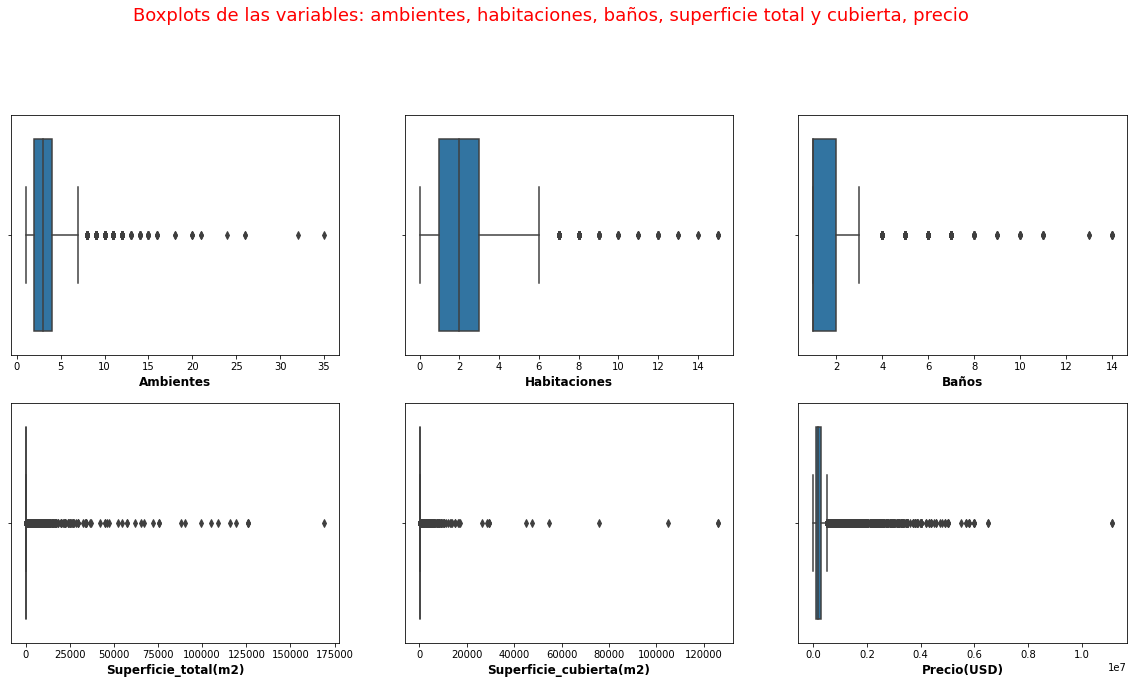

In [14]:
#Graficamos diagramas de caja para cada variable para recordar su distribución
columnas = ["Ambientes", "Habitaciones", "Baños", "Superficie_total(m2)", "Superficie_cubierta(m2)", "Precio(USD)"]

plt.figure(figsize=(20,15))
plt.suptitle("Boxplots de las variables: ambientes, habitaciones, baños, superficie total y cubierta, precio", fontsize=18, color = "r")
for idx, i in enumerate(columnas, start = 1):
    plt.subplot(3,3,idx)
    sns.boxplot(x = propiedades[i])
    plt.xlabel(i, fontweight = "black", fontsize = 12)

In [15]:
out = ["Ambientes", "Habitaciones", "Baños", "Superficie_total(m2)", "Superficie_cubierta(m2)", "Precio(USD)"]

seleccion = propiedades[~ ((propiedades[out] > propiedades[out].quantile(0.95)) | (propiedades[out] < propiedades[out].quantile(0.01))).any(axis = 1)].copy()

seleccion_old = propiedades[propiedades.Ubicacion == "Capital Federal"]
seleccion_old = seleccion_old[~ ((seleccion_old[out] > seleccion_old[out].quantile(0.99)) | (seleccion_old[out] < seleccion_old[out].quantile(0.01))).any(axis = 1)].copy()

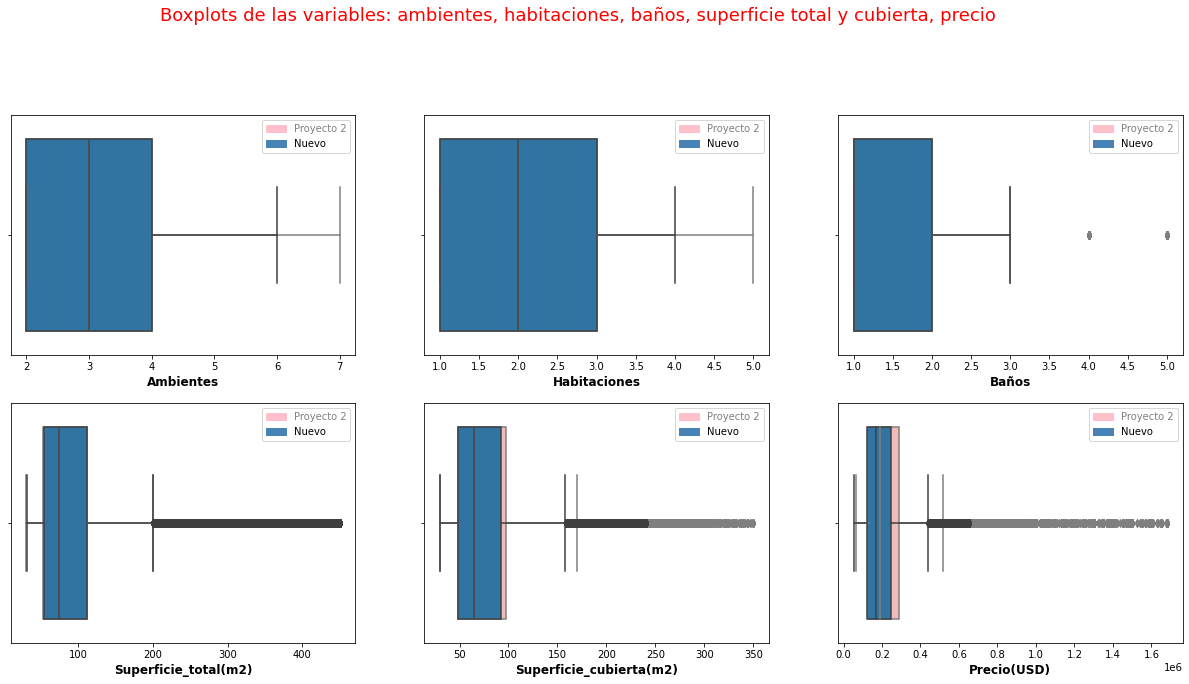

In [16]:
plt.figure(figsize=(21,15))
plt.suptitle("Boxplots de las variables: ambientes, habitaciones, baños, superficie total y cubierta, precio", fontsize=18, color = "r")
for idx, i in enumerate(columnas, start = 1):
    plt.subplot(3,3,idx)
    sns.boxplot(x = seleccion_old[i], palette  = "Pastel1")
    sns.boxplot(x = seleccion[i])
    plt.xlabel(i, fontweight = "black", fontsize = 12)
    patch1 = mpatches.Patch(color='pink', label='Proyecto 2')
    patch2 = mpatches.Patch(color='steelblue', label='Nuevo')
    plt.legend(handles=[patch1, patch2], labelcolor = ["gray", "black"])
    if idx == 8:
        plt.xticks(rotation = 45)

In [17]:
print("Tamaño del conjunto de datos con el nuevo filtrado:", seleccion.shape, "\nTamaño del conjunto de datos con el viejo filtrado:", seleccion_old.shape)

Tamaño del conjunto de datos con el nuevo filtrado: (97054, 11) 
Tamaño del conjunto de datos con el viejo filtrado: (70882, 11)


### Imputación de datos faltantes

Se imputaron los datos faltantes en Latitud y Longitud usando el promedio de las mismas agrupadas según el Barrio y se eliminaron las instancias con datos faltantes en "Baños" ya que no son muchos y es un valor más dificil de estimar y puede inferir errores innecesarios en nuestro dataset.

In [18]:
print("Cantidad de valores faltantes por columna:\n", seleccion.isna().sum(), sep = "")

Cantidad de valores faltantes por columna:
Latitud                    6332
Longitud                   6332
Ubicacion                     0
Barrios                       0
Ambientes                     0
Habitaciones                  0
Baños                      1274
Superficie_total(m2)          0
Superficie_cubierta(m2)       0
Precio(USD)                   0
Tipo_propiedad                0
dtype: int64


In [19]:
#Imputación de los datos
seleccion["Latitud"].fillna(seleccion.groupby("Barrios")["Latitud"].transform('mean'), inplace = True)
seleccion["Longitud"].fillna(seleccion.groupby("Barrios")["Longitud"].transform('mean'), inplace = True)

In [20]:
#Eliminación de faltantes restantes y reseteo de indices
seleccion = seleccion.dropna()
seleccion.reset_index(drop = True, inplace = True)

In [21]:
print("Tamaño del conjunto de datos filtrado:", seleccion.shape)

Tamaño del conjunto de datos filtrado: (95780, 11)


### Encoding

Como se realizó en el proyecto 2, se aplicó One Hot Encoding a la variable "Tipo de propiedad" y también se lo aplicamos en esta oportunidad a la variable "Barrios" para, cómo ya se dijo al principio, ver si mejora el modelo en reemplazo de las variables "latitud" y "longitud".

In [22]:
encoder = OneHotEncoder(sparse=False)
encoder2 = OneHotEncoder(sparse=False)

In [23]:
p_type = encoder.fit_transform(seleccion[["Tipo_propiedad"]])
p_location = encoder2.fit_transform(seleccion[["Ubicacion"]])

In [24]:
print(encoder.categories_)
print(encoder2.categories_)

[array(['Casa', 'Departamento', 'PH'], dtype=object)]
[array(['Bs.As. G.B.A.', 'Capital Federal'], dtype=object)]


In [25]:
seleccion[encoder.categories_[0]] = p_type
seleccion[encoder2.categories_[0]] = p_location

In [26]:
seleccion.head()

,Latitud,Longitud,Ubicacion,Barrios,Ambientes,Habitaciones,Baños,Superficie_total(m2),Superficie_cubierta(m2),Precio(USD),Tipo_propiedad,Casa,Departamento,PH,Bs.As. G.B.A.,Capital Federal
0,-34.624056,-58.412110,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH,0.0,0.0,1.0,0.0,1.0
1,-34.593569,-58.427474,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH,0.0,0.0,1.0,0.0,1.0
2,-34.581294,-58.436754,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH,0.0,0.0,1.0,0.0,1.0
3,-34.593779,-58.441239,Capital Federal,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH,0.0,0.0,1.0,0.0,1.0
4,-34.600988,-58.433061,Capital Federal,Villa Crespo,2.0,1.0,1.0,70.0,70.0,159500.0,PH,0.0,0.0,1.0,0.0,1.0


### Nuevas variables predictoras

Se agregaron dos variables nuevas: **"Proporción cubierta"**, generada a partir de la división de la "Superficie cubierta" sobre la "Superficie total", y **"Cantidad de baños por habitación"**, generada a partir de la división del Nro de baños por el Nro de habitaciones.

In [27]:
#Proporción cubierta
seleccion["Proporcion_cubierta"] = seleccion["Superficie_cubierta(m2)"]/seleccion["Superficie_total(m2)"]

In [28]:
#Cantidad de baños por habitación
seleccion["Baños/Habitaciones"] = seleccion.Baños/seleccion.Habitaciones

### Correlaciones

Text(0.5, 1.0, 'Coeficientes de correlación (Pearson)')

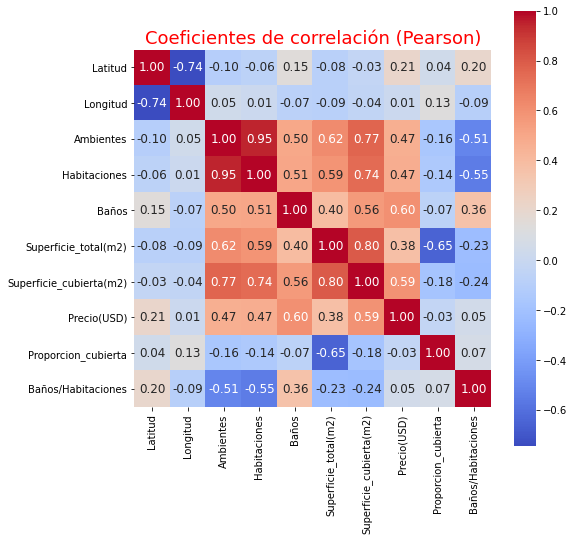

In [29]:
data_corr = seleccion.drop(columns = ["Casa", "Departamento", "PH", "Capital Federal", "Bs.As. G.B.A."])
corr = data_corr.corr()

plt.figure(figsize = (8,8))
sns.heatmap(corr, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'size': 12}, cmap= 'coolwarm')
plt.xticks(rotation = 90)
plt.title("Coeficientes de correlación (Pearson)", fontsize = 18, color = "r")

Al volver a analizar las correlaciones se vió que estás se modificaron significativamente en comparación con lo observado anteriormente:
* En el Proyecto 2, las variables que poseían un coeficiente de correlación con la variable "Precio" superior a 0.5 eran (en orden decreciente), "Superfie cubierta", "Superficie total, "Baños", "Ambientes", y "Habitaciones. Sin embargo, ahora vemos que las únicas variables que poseen una correlación superior a 0.5 con la variable "Precio" son "Superficie cubierta" y "Baños". "Ambientes" y "Habitaciones" disminuyeron su correlación un poco y "Superficie total" disminuyó de manera muy considerable.

Por otro lado se mantuvo que:
* Las variables "Superficie Total" y "Superficie cubierta", como es de esperarse, están altamente relacionadas entre sí.
* Al igual que las superficies, las variables "Ambientes" y "Habitaciones" también están muy relacionadas entre sí.

A continuación se realizó el mismo análisis pero para cada tipo de propiedad por separado.

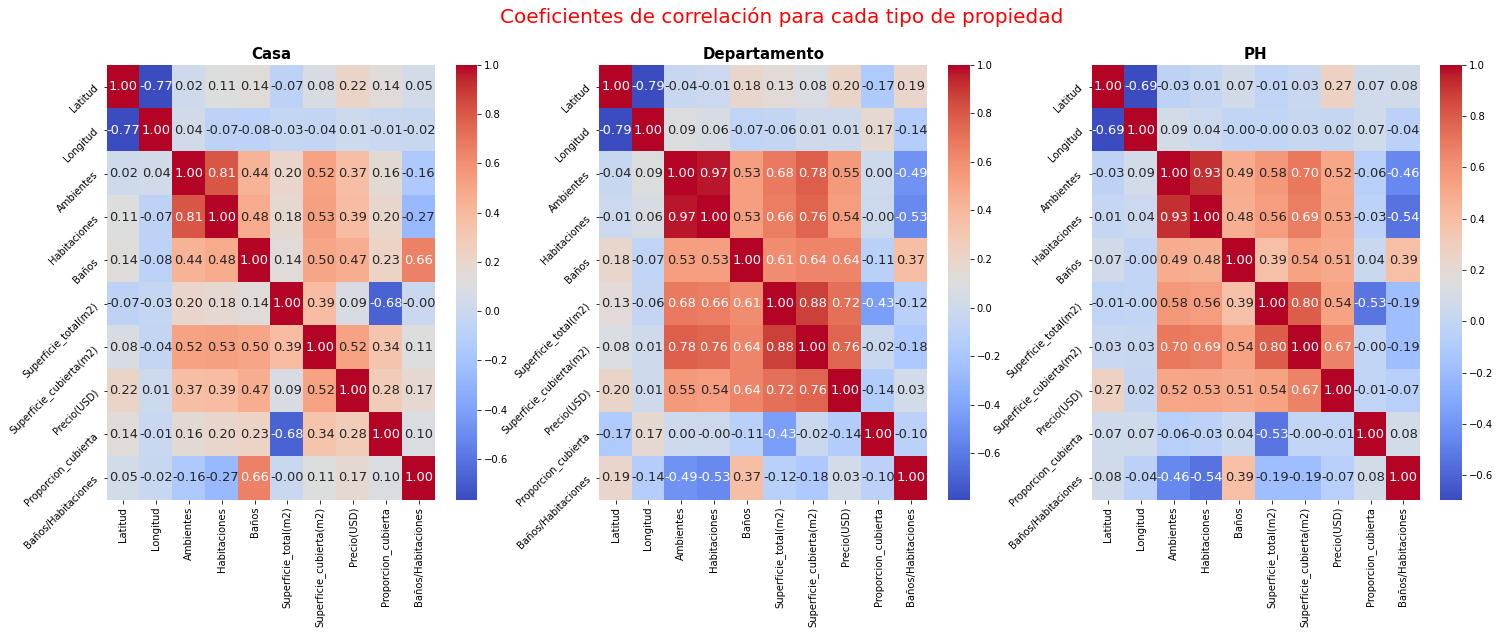

In [30]:
tipos = ["Casa", "Departamento", "PH"]

plt.figure(figsize=(25,8))
plt.suptitle("Coeficientes de correlación para cada tipo de propiedad", fontsize = 20, color = "r")
for idx, i in enumerate(tipos, start = 1):
    corr = data_corr[data_corr.Tipo_propiedad == i].corr()
    plt.subplot(1,3,idx)
    sns.heatmap(corr, cbar = True, annot=True, fmt= '.2f',annot_kws={'size': 13}, cmap= 'coolwarm')
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 45)
    plt.title(i, fontweight = "black", fontsize = 15)

Al dividir el análisis por el tipo de propiedad podemos ver que para el caso de los Departamentos y PH se mantienen las mismas relaciones vistas en el proyecto anterior. Sin embargo, para las Casas se pueden apreciar las mismas relaciones vistas en el cálculo anterior.

Por último se calculó nuevamente las correlaciones pero dividiendo esta vez según la ubicación.

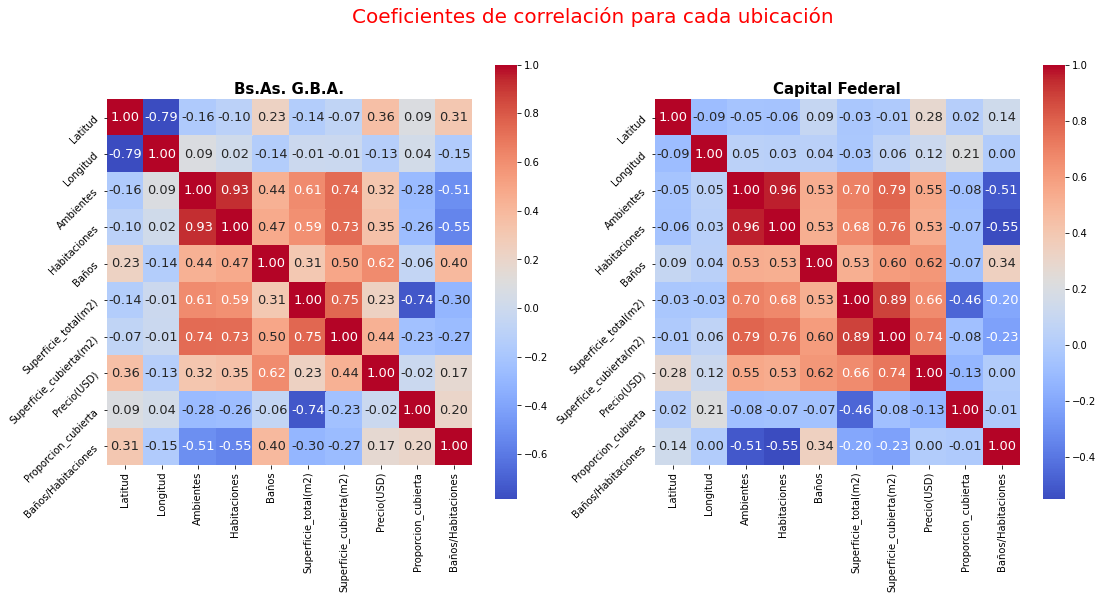

In [31]:
ubicacion = ["Bs.As. G.B.A.", "Capital Federal"]

plt.figure(figsize=(18,8))
plt.suptitle("Coeficientes de correlación para cada ubicación", fontsize = 20, color = "r")
for idx, i in enumerate(ubicacion, start = 1):
    corr = data_corr[data_corr.Ubicacion == i].corr()
    plt.subplot(1,2,idx)
    sns.heatmap(corr, cbar = True, square = True, annot=True, fmt= '.2f',annot_kws={'size': 13}, cmap= 'coolwarm')
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 45)
    plt.title(i, fontweight = "black", fontsize = 15)

Para Capital Federal vemos las mismas relación que en el proyecto anterior, y para Gran Buenos Aires vemos que la mayor correlación para el Precio es "Baños y las otras variables sufren una disminución considerable, a excepción de la variable "Latitud" la cual presenta la mayor correlación entre estas dos variables (Precio y Latitud) vista entre todos los análisis realizados.

### Definición de una función para aplicar y evaluar los modelos

Ya finalizado el análisis de los datos, se definió una función para aplicar cada vez que se cree un modelo y se requiera evaluar su desempeño.

In [32]:
def Aplicar_modelo(X_train, X_test, y_train, y_test, modelo):
    
    modelo.fit(X_train, y_train)
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)
    
    rmse_train = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    plt.figure(figsize = (15,6))
    plt.suptitle("Histograma de los errores (y - y_predicho) para cada conjunto y Gráfico de dispersión de 'y' vs 'y-predicho' (Test)", fontsize = 18, color = "r")

    plt.subplot(1,2,1)
    sns.histplot(y_train - y_train_pred, bins = 30, label = 'train', color = "green")
    sns.histplot(y_test - y_test_pred, bins = 30, label = 'test')
    plt.xlabel("Errores", fontweight = "black", fontsize = 12)
    plt.xticks(rotation = 45, horizontalalignment="right")
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(y_test, y_test_pred, s=1) 
    plt.xlabel("Valores originales del Precio (USD)", fontweight = "black", fontsize = 12)
    plt.ylabel("Valores predichos del Precio (USD)", fontweight = "black", fontsize = 12)
    plt.xticks(rotation = 45, horizontalalignment="right")
    
    return rmse_train, rmse_test

### Benchmark

El mejor modelo obtenido en el Proyecto 2 fue:  **XGBoost**

_Parámetros:_
* 'n_estimators' = 150
* 'max_depth' = 10
* 'learning_rate' = 0.25

_Variables:_
* "Latitud"
* "Longitud"
* "Superficie_cubierta(m2)"
* "Casa"
* "Departamento"
* "PH"
* "Baños/Habitaciones"
* "Proporcion_cubierta"

_RMSE:_
* Train = 20226
* Test = 51296

Recordemos que se trabajó solo con los datos de Capital Federal (Datos en Train: 49142, Datos en Test: 21062, Test size: 0.3%)

### Modelos

Para empezar se probó el modelo obtenido anteriormente con los nuevos datos, utilizando las mismas variables.

In [33]:
#Definición de X e Y
X = seleccion[["Latitud", "Longitud", "Superficie_cubierta(m2)", "Casa", "Departamento", "PH", "Baños/Habitaciones", "Proporcion_cubierta"]]
Y = seleccion["Precio(USD)"]

In [34]:
#Train-Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [35]:
#Creación del modelo
xgb_reg = xgb.XGBRegressor(random_state = 42, n_jobs = -1, n_estimators = 150, max_depth = 10, learning_rate = 0.25)

Raíz del error cuadrático medio en Train: 19726.142691965993
Raíz del error cuadrático medio en Test: 34975.28925140627


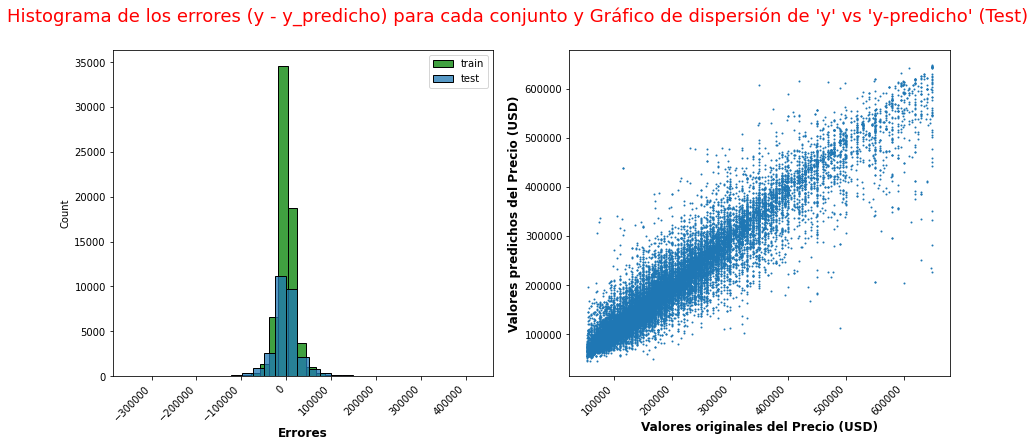

In [36]:
#Entrenamiento y evaluación
rmse_train, rmse_test = Aplicar_modelo(X_train, X_test, Y_train, Y_test, xgb_reg)

Con los nuevos datos se obtuvo un mejor rendimiento del modelo obtenido anteriormente, disminuyendo considerablemente el RMSE en Test.

A continuación vamos a probar un nuevo modelo, agregando las variables "Capital Federal" y "Bs.As. G.B.A.", y volviendo a buscar los mejores hiperparámetros ya que al agregar variables y datos pueden haber cambiado.

In [37]:
X2 = seleccion[["Latitud", "Longitud", "Superficie_cubierta(m2)", "Casa", "Departamento", "PH", "Capital Federal", "Bs.As. G.B.A.", "Baños/Habitaciones", "Proporcion_cubierta"]]

In [38]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y, test_size = 0.3, random_state = 42)

In [39]:
parameters = {'n_estimators':[150, 200, 250, 300],
              'max_depth':[5, 10, 25],
              'learning_rate':[0.1, 0.25, 0.5, 0.75]}

In [40]:
xgb_model = xgb.XGBRegressor(random_state = 42, n_jobs = -1)
xgb_reg2 = RandomizedSearchCV(xgb_model, parameters, cv=5, random_state = 42, n_jobs = -1)

Raíz del error cuadrático medio en Train: 14207.11374789316
Raíz del error cuadrático medio en Test: 33754.460497094056


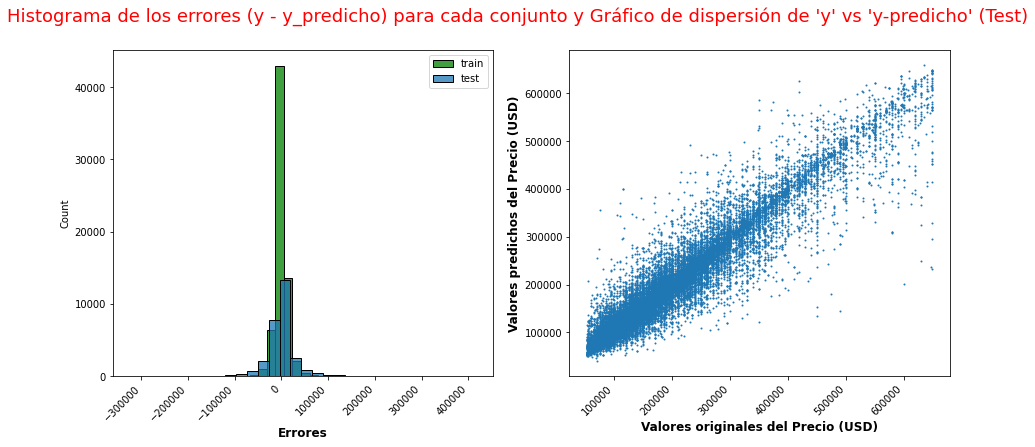

In [41]:
rmse_train2, rmse_test2 = Aplicar_modelo(X2_train, X2_test, Y2_train, Y2_test, xgb_reg2)

In [42]:
print("Mejores parametros: "+str(xgb_reg2.best_params_))

Mejores parametros: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.25}


In [43]:
resumen1 = {"Modelo":["Proyecto 2 con nuevos datos", "Nuevos datos y variables"], 
           "Número de estimadores":[xgb_reg.n_estimators, xgb_reg2.best_estimator_.n_estimators],
           "Profundidad máxima":[xgb_reg.max_depth, xgb_reg2.best_params_["max_depth"]],
           "Cantidad de Variables": [X.columns.shape[0], X2.columns.shape[0]], 
           "RMSE (test)":[np.round(rmse_test,2), np.round(rmse_test2,2)],
           "RMSE (train)":[np.round(rmse_train,2), np.round(rmse_train2,2)]}
pd.DataFrame(resumen1)

,Modelo,Número de estimadores,Profundidad máxima,Cantidad de Variables,RMSE (test),RMSE (train)
0,Proyecto 2 con nuevos datos,150,10,8,34975.29,19726.14
1,Nuevos datos y variables,300,10,10,33754.46,14207.11


Agregando las variables nuevas mejora un poco el modelo pero no significativamente.

Ahora vamos a probar la división del modelo en varios según el tipo de propiedad o la ubicación.
* **Dos modelos: Uno para Capital y otro para G.B.A.**

Para el modelo de Capital se utilizaron las mismas variables que en el Proyecto 2, pero para G.B.A. se reemplazó la variable "Baños/Habitaciones" por "Baños" debido a la gran correlación que tiene esta con "Precio" al dividir el análisis.

In [44]:
#División de datos
capital = seleccion[seleccion.Ubicacion == "Capital Federal"]
gran_BsAs = seleccion[seleccion.Ubicacion == "Bs.As. G.B.A."]

In [45]:
#Definición de las X e Y
X_cap = capital[["Latitud", "Longitud", "Superficie_cubierta(m2)", "Casa", "Departamento", "PH", "Baños/Habitaciones", "Proporcion_cubierta"]]
X_gba = gran_BsAs[["Latitud", "Longitud", "Superficie_cubierta(m2)", "Casa", "Departamento", "PH", "Proporcion_cubierta", "Baños"]]
Y_cap = capital["Precio(USD)"]
Y_gba = gran_BsAs["Precio(USD)"]

In [46]:
#Train-Test split
Xcap_train, Xcap_test, Ycap_train, Ycap_test = train_test_split(X_cap, Y_cap, test_size = 0.3, random_state = 42)
Xgba_train, Xgba_test, Ygba_train, Ygba_test = train_test_split(X_gba, Y_gba, test_size = 0.3, random_state = 42)

In [47]:
#Creación de modelos
xgb1 = xgb.XGBRegressor(random_state = 42, n_jobs = -1)
xgb2 = xgb.XGBRegressor(random_state = 42, n_jobs = -1)

In [48]:
#Optimización utilizando los mismos parámetros definidos anteriormente
xgb_cap = RandomizedSearchCV(xgb1, parameters, cv=5, random_state = 42, n_jobs = -1)
xgb_gba = RandomizedSearchCV(xgb2, parameters, cv=5, random_state = 42, n_jobs = -1)

Raíz del error cuadrático medio en Train: 10648.466843397147
Raíz del error cuadrático medio en Test: 31626.08593120393


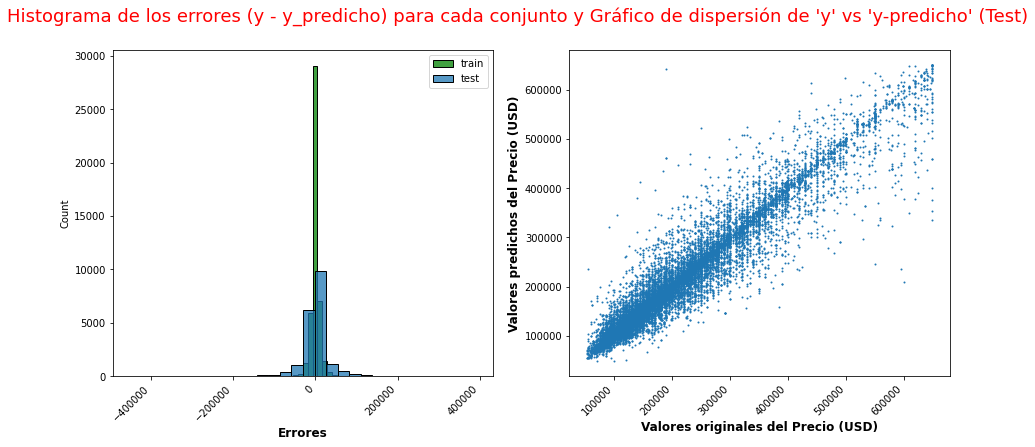

In [49]:
#Entrenamiento y evaluación (Capital)
rmse_trainCap, rmse_testCap = Aplicar_modelo(Xcap_train, Xcap_test, Ycap_train, Ycap_test, xgb_cap)

In [50]:
print("Mejores parametros: "+str(xgb_cap.best_params_))

Mejores parametros: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.25}


Raíz del error cuadrático medio en Train: 9807.530640416915
Raíz del error cuadrático medio en Test: 36407.502151556306


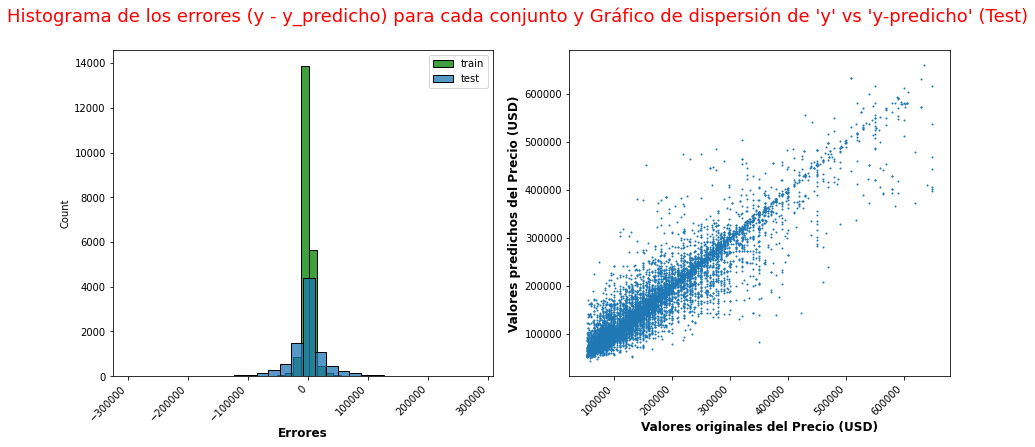

In [51]:
#Entrenamiento y evaluación (G.B.A.)
rmse_trainGba, rmse_testGba = Aplicar_modelo(Xgba_train, Xgba_test, Ygba_train, Ygba_test, xgb_gba)

In [52]:
print("Mejores parametros: "+str(xgb_gba.best_params_))

Mejores parametros: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.25}


In [53]:
resumen2 = {"Modelo":["Capital", "G.B.A."], 
           "Número de estimadores":[xgb_cap.best_estimator_.n_estimators, xgb_gba.best_estimator_.n_estimators],
           "Profundidad máxima":[xgb_cap.best_params_["max_depth"], xgb_gba.best_params_["max_depth"]],
           "Cantidad de Variables": [X_cap.columns.shape[0], X_gba.columns.shape[0]], 
           "RMSE (test)":[np.round(rmse_testCap,2), np.round(rmse_testGba,2)],
           "RMSE (train)":[np.round(rmse_trainCap,2), np.round(rmse_trainGba,2)]}
pd.DataFrame(resumen2)

,Modelo,Número de estimadores,Profundidad máxima,Cantidad de Variables,RMSE (test),RMSE (train)
0,Capital,300,10,8,31626.09,10648.47
1,G.B.A.,300,10,8,36407.50,9807.53


Para el modelo de Capital se mejoró el rendimiento pero no así en el modelo de G.B.A. Es posible que esto se deba a la diferencia en la cantidad de datos para cada modelo ya que los datos de G.B.A. son la mitad que para Capital Federal

In [54]:
print("Cantidad de datos en Train para Capital: "+str(Xcap_train.shape[0]), "\nCantidad de datos en Train para G.B.A.: "+str(Xgba_train.shape[0]))

Cantidad de datos en Train para Capital: 45788 
Cantidad de datos en Train para G.B.A.: 21257


* **Tres modelos: Uno para cada tipo de propiedad.**

In [55]:
#División de datos
casa = seleccion[seleccion.Tipo_propiedad == "Casa"]
dpto = seleccion[seleccion.Tipo_propiedad == "Departamento"]
ph = seleccion[seleccion.Tipo_propiedad == "PH"]

In [56]:
#Definición de las X e Y
X_casa = casa[["Latitud", "Longitud", "Superficie_cubierta(m2)", "Capital Federal", "Bs.As. G.B.A.", "Proporcion_cubierta", "Baños"]]
X_dpto = dpto[["Latitud", "Longitud", "Superficie_cubierta(m2)", "Capital Federal", "Bs.As. G.B.A.", "Baños/Habitaciones", "Proporcion_cubierta"]]
X_ph = ph[["Latitud", "Longitud", "Superficie_cubierta(m2)", "Capital Federal", "Bs.As. G.B.A.", "Baños/Habitaciones", "Proporcion_cubierta"]]
Y_casa = casa["Precio(USD)"]
Y_dpto = dpto["Precio(USD)"]
Y_ph = ph["Precio(USD)"]

In [57]:
#Train-Test split
Xcasa_train, Xcasa_test, Ycasa_train, Ycasa_test = train_test_split(X_casa, Y_casa, test_size = 0.3, random_state = 42)
Xdpto_train, Xdpto_test, Ydpto_train, Ydpto_test = train_test_split(X_dpto, Y_dpto, test_size = 0.3, random_state = 42)
Xph_train, Xph_test, Yph_train, Yph_test = train_test_split(X_ph, Y_ph, test_size = 0.3, random_state = 42)

In [58]:
#Creación de modelos
xgb3 = xgb.XGBRegressor(random_state = 42, n_jobs = -1)
xgb4 = xgb.XGBRegressor(random_state = 42, n_jobs = -1)
xgb5 = xgb.XGBRegressor(random_state = 42, n_jobs = -1)

In [59]:
#Optimización utilizando los mismos parámetros definidos anteriormente
xgb_casa = RandomizedSearchCV(xgb3, parameters, cv=5, random_state = 42, n_jobs = -1)
xgb_dpto = RandomizedSearchCV(xgb4, parameters, cv=5, random_state = 42, n_jobs = -1)
xgb_ph = RandomizedSearchCV(xgb5, parameters, cv=5, random_state = 42, n_jobs = -1)

Raíz del error cuadrático medio en Train: 12950.838246426336
Raíz del error cuadrático medio en Test: 48455.74642952632


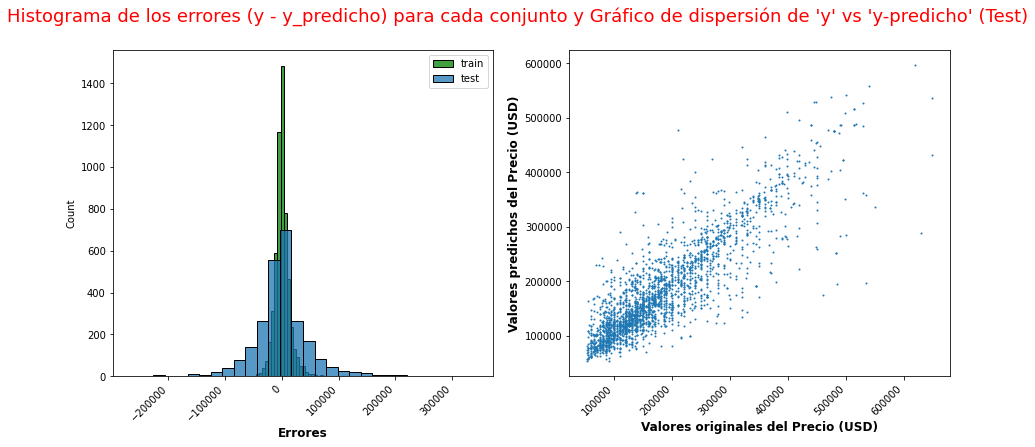

In [60]:
#Entrenamiento y evaluación (Casa)
rmse_trainCasa, rmse_testCasa = Aplicar_modelo(Xcasa_train, Xcasa_test, Ycasa_train, Ycasa_test, xgb_casa)

In [61]:
print("Mejores parametros: "+str(xgb_casa.best_params_))

Mejores parametros: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.1}


Raíz del error cuadrático medio en Train: 12730.54709655456
Raíz del error cuadrático medio en Test: 31598.875424097503


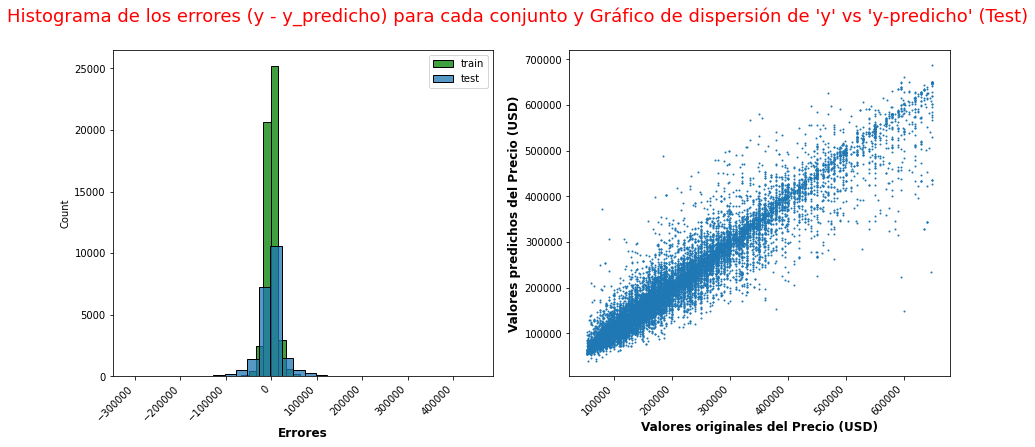

In [62]:
#Entrenamiento y evaluación (Departamento)
rmse_trainDpto, rmse_testDpto = Aplicar_modelo(Xdpto_train, Xdpto_test, Ydpto_train, Ydpto_test, xgb_dpto)

In [63]:
print("Mejores parametros: "+str(xgb_dpto.best_params_))

Mejores parametros: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.25}


Raíz del error cuadrático medio en Train: 4496.233560351875
Raíz del error cuadrático medio en Test: 32252.53448252802


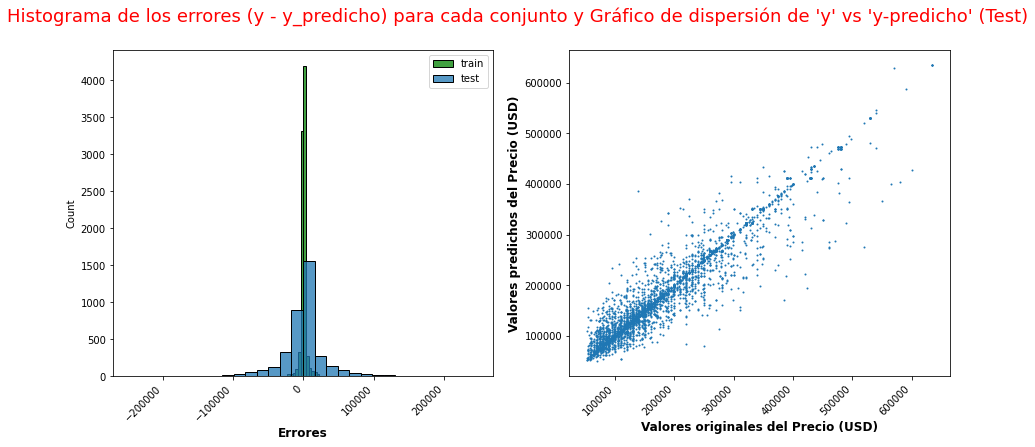

In [64]:
#Entrenamiento y evaluación (PH)
rmse_trainPh, rmse_testPh = Aplicar_modelo(Xph_train, Xph_test, Yph_train, Yph_test, xgb_ph)

In [65]:
print("Mejores parametros: "+str(xgb_ph.best_params_))

Mejores parametros: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.25}


In [66]:
resumen3 = {"Modelo":["Casa", "PH", "Departamento"], 
           "Número de estimadores":[xgb_casa.best_estimator_.n_estimators, xgb_ph.best_estimator_.n_estimators, xgb_dpto.best_estimator_.n_estimators],
           "Profundidad máxima":[xgb_casa.best_params_["max_depth"], xgb_ph.best_params_["max_depth"], xgb_dpto.best_params_["max_depth"]],
           "Cantidad de Variables": [X_casa.columns.shape[0], X_ph.columns.shape[0], X_dpto.columns.shape[0]], 
           "RMSE (test)":[np.round(rmse_testCasa,2), np.round(rmse_testPh,2), np.round(rmse_testDpto,2)],
           "RMSE (train)":[np.round(rmse_trainCasa,2), np.round(rmse_trainPh,2), np.round(rmse_trainDpto,2)]}
pd.DataFrame(resumen3)

,Modelo,Número de estimadores,Profundidad máxima,Cantidad de Variables,RMSE (test),RMSE (train)
0,Casa,150,10,7,48455.75,12950.84
1,PH,300,10,7,32252.53,4496.23
2,Departamento,300,10,7,31598.88,12730.55


Para este caso se obtuvo una mejora en los modelos para Departamento y PH, pero para Casa el resultado fue peor. Esta diferencia en los resultados podemos atribuirselos también a la diferencia en la cantidad de datos, pero llama la atención el rendimiento similar que tuvieron los modelos para Departamento y PH, siendo significativamente menor la cantidad de datos para PH que tenemos.

In [67]:
print("Cantidad de datos en Train para Departamento: "+str(Xdpto_train.shape[0]), "\nCantidad de datos en Train para PH: "+str(Xph_train.shape[0]), "\nCantidad de datos en Train para Casa: "+str(Xcasa_train.shape[0]))

Cantidad de datos en Train para Departamento: 52722 
Cantidad de datos en Train para PH: 8611 
Cantidad de datos en Train para Casa: 5712


### Resumen y conclusión

In [68]:
resumen = {}

resumen["Modelo"] = resumen1["Modelo"] + resumen2["Modelo"] + resumen3["Modelo"]
resumen["Variables"] = resumen1["Cantidad de Variables"] + resumen2["Cantidad de Variables"] + resumen3["Cantidad de Variables"]
resumen["RMSE (test)"] = resumen1["RMSE (test)"] + resumen2["RMSE (test)"] + resumen3["RMSE (test)"]
resumen["RMSE (train)"] = resumen1["RMSE (train)"] + resumen2["RMSE (train)"] + resumen3["RMSE (train)"]

In [69]:
resumen = pd.DataFrame(resumen)
resumen

,Modelo,Variables,RMSE (test),RMSE (train)
0,Proyecto 2 con nuevos datos,8,34975.29,19726.14
1,Nuevos datos y variables,10,33754.46,14207.11
2,Capital,8,31626.09,10648.47
3,G.B.A.,8,36407.50,9807.53
4,Casa,7,48455.75,12950.84
5,PH,7,32252.53,4496.23
6,Departamento,7,31598.88,12730.55


En base a los resultados obtenidos, se pudo mejorar y expandir el alcance del modelo resultante del Proyecto 2. Puntualizando los objetivos para este proyecto, pudimos agregar los datos de Gran Buenos Aires sin disminuir la eficiencia de nuestro modelo, y pudimos incluso mejorar sus resultados al modificar los límites para la eliminación de outliers. Esto último se puede confirmar en el modelo que fue entrenado solo con los datos de Capital Federal, el cuál da como resultado un RMSE mucho menor al obtenido en el proyecto anterior. Comparando este resultado con el modelo que presenta todos los datos juntos, vemos que aumenta un poco el RMSE pero no es un aumento tan significativo.

Por otro lado, el objetivo de obtener mejores resultados al dividir los modelos según la ubicación o el tipo de propiedad no resultó de forma efectiva ya que en algunos casos, como el modelo para las Casas o Gran Buenos Aires, se obtuvo un aumento en el RMSE. Sin embargo, cabe la posibilidad (principalmente en la división según la ubicación) de que se puedan obtener mejores resultados si contamos con la misma cantidad de datos para ambos conjuntos.

En conclusión, nuestro nuevo mejor modelo para predecir el precio de las propiedades en Buenos Aires es el segundo realizado, el cual consta de las siguientes características:

**Modelo XGBoost**

_Parámetros:_
* 'n_estimators' = 300
* 'max_depth' = 10
* 'learning_rate' = 0.25

_Variables:_
* "Latitud"
* "Longitud"
* "Superficie_cubierta(m2)"
* "Casa"
* "Departamento"
* "PH"
* "Capital Federal"
* "Bs.As. G.B.A."
* "Baños/Habitaciones"
* "Proporcion_cubierta"

Por último se analizó la importancia de las variables en este modelo.

In [71]:
result = permutation_importance(xgb_reg2, X2, Y, n_repeats = 10, random_state = 42)

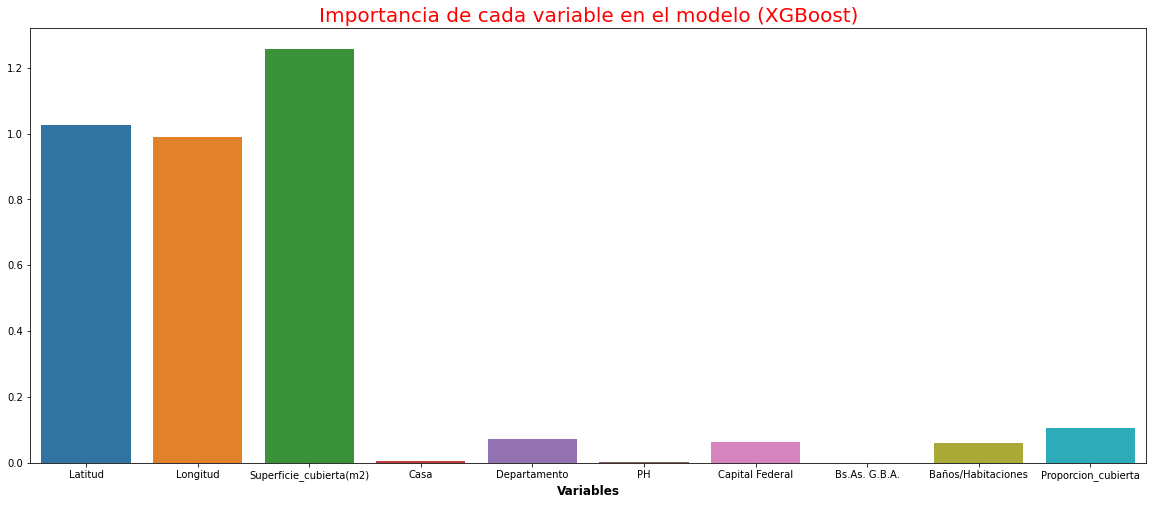

In [72]:
importances = result.importances_mean
columns = X2.columns

plt.figure(figsize = (20,8))
sns.barplot(x = columns, y = importances)
plt.title("Importancia de cada variable en el modelo (XGBoost)", fontsize = 20, color = "r")
plt.xlabel("Variables", fontweight = "black", fontsize = 12)
plt.show()

Finalmente, en cuanto a la importancia de las variables, la más importante sigue siendo la "Superficie cubierta", y luego siguen la "Latitud" y "Longitud" pero en este modelo tiene más importancia que en el Proyecto anterior.